In [3]:
import os
import tempfile
import shutil
import urllib
import zipfile
from collections import Counter
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [4]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [5]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(training_small_url, force_download=True, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

['behaviors.tsv',
 'news.tsv',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_train.zip',
 'MINDsmall_train.zip',
 'entity_embedding.vec',
 'relation_embedding.vec']

In [6]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
df = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

In [ ]:
print(df)
print(df.dtypes)

In [7]:
df['num_articles'] = df['impressions'].str.split(" ").str.len()
df['len_history'] = df['history'].str.split(" ").str.len()
df['month'] = df['time'].apply(lambda x : int(pd.Series(x.split(" "))[0].split("/")[0]))
df['day'] = df['time'].apply(lambda x : int(pd.Series(x.split(" "))[0].split("/")[1]))
df['num_impressions'] = 1
# print(df.dtypes)
# df.describe()

array([[<AxesSubplot:title={'center':'day'}>]], dtype=object)

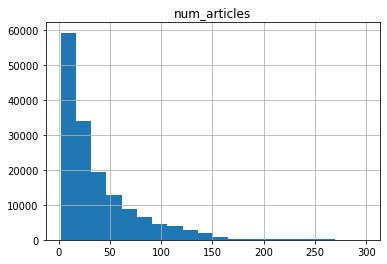

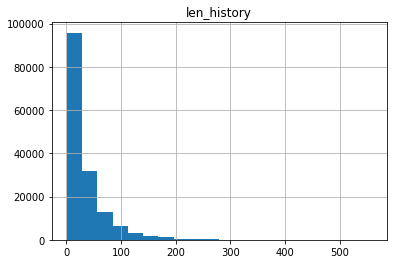

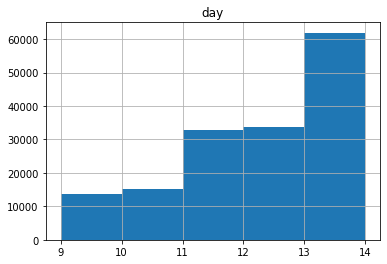

In [8]:
df.hist(column='num_articles', bins=20)
df.hist(column='len_history', bins=20)
df.hist(column='day', bins=5)

In [9]:
df['clicks'] = df['impressions'].apply(lambda x : Counter(pd.Series(x.split(" ")).str.slice(start=-1))['1'])
df['no_clicks'] = df['num_articles'] - df['clicks']
# print(df.dtypes)
print(df)

        impression_id user_id                    time  \
0                   1  U13740   11/11/2019 9:05:58 AM   
1                   2  U91836   11/12/2019 6:11:30 PM   
2                   3  U73700   11/14/2019 7:01:48 AM   
3                   4  U34670   11/11/2019 5:28:05 AM   
4                   5   U8125   11/12/2019 4:11:21 PM   
...               ...     ...                     ...   
156960         156961  U21593  11/14/2019 10:24:05 PM   
156961         156962  U10123   11/13/2019 6:57:04 AM   
156962         156963  U75630  11/14/2019 10:58:13 AM   
156963         156964  U44625   11/13/2019 2:57:02 PM   
156964         156965  U64800   11/14/2019 3:25:49 PM   

                                                  history  \
0       N55189 N42782 N34694 N45794 N18445 N63302 N104...   
1       N31739 N6072 N63045 N23979 N35656 N43353 N8129...   
2       N10732 N25792 N7563 N21087 N41087 N5445 N60384...   
3       N45729 N2203 N871 N53880 N41375 N43142 N33013 ...   
4         

In [10]:
user_df = df.groupby(['user_id']).agg(lambda x: x.sum())
# user_df2 = df.groupby(['user_id']).var()
user_df = user_df.drop('impression_id', axis=1)
user_df = user_df.drop('time', axis=1)
user_df['%clicks'] = user_df['clicks']/user_df['num_articles']
print(user_df)
user_df.describe()

                                                   history  \
user_id                                                      
U100     N20121 N33998 N45954 N55743 N50095 N18870 N534...   
U1000    N29641 N1789 N41244N29641 N1789 N41244N29641 N...   
U10001   N47937 N51706 N56447 N61319 N27644 N18030 N272...   
U10003   N39074 N26619 N31431 N1282 N61052 N41668 N5083...   
U10008   N23912 N30148 N46754 N33117 N9619 N36526 N4449...   
...                                                    ...   
U9993                                        N47458 N14114   
U9995    N61471 N61704 N49103 N63554 N44399 N32117 N218...   
U9996    N28296 N4719 N60340 N31165 N8448N28296 N4719 N...   
U9997    N46759 N46990 N9072 N11727 N50744 N38367 N3333...   
U9999    N64503 N20039 N447 N10865 N59026 N12972 N25577...   

                                               impressions  num_articles  \
user_id                                                                    
U100     N61235-0 N54489-0 N42597-0 N7800

,num_articles,len_history,month,day,num_impressions,clicks,no_clicks,%clicks
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,116.868880,102.15278,34.532300,37.442780,3.139300,4.726880,112.142000,0.085461
std,145.809655,346.84318,33.011283,35.902204,3.001026,5.768136,141.331886,0.104511
min,2.000000,0.00000,11.000000,9.000000,1.000000,1.000000,1.000000,0.003448
25%,25.000000,8.00000,11.000000,13.000000,1.000000,1.000000,23.000000,0.028986
50%,67.000000,20.00000,22.000000,25.000000,2.000000,3.000000,64.000000,0.048544
75%,152.000000,68.00000,44.000000,47.000000,4.000000,6.000000,147.000000,0.090909
max,1960.000000,18972.00000,682.000000,737.000000,62.000000,129.000000,1919.000000,0.666667


KeyError: "None of [Index(['day_var'], dtype='object')] are in the [columns]"

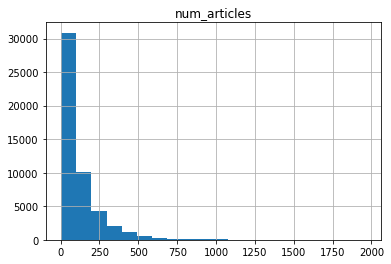

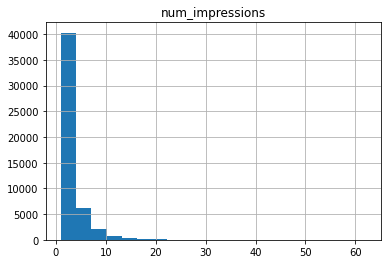

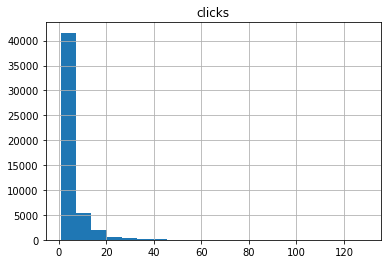

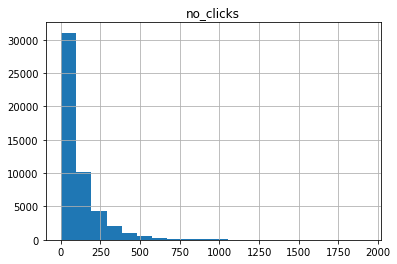

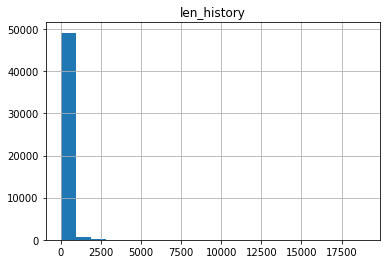

In [11]:
user_df.hist(column='num_articles', bins=20)
user_df.hist(column='num_impressions', bins=20)
user_df.hist(column='clicks', bins=20)
user_df.hist(column='no_clicks', bins=20)
user_df.hist(column='len_history', bins=20)
user_df.hist(column='day_var', bins=20)
user_df.describe()

In [12]:
impression_table = user_df['impressions'].apply(lambda x : pd.Series(x.split(" ")))

In [13]:
impression_table

,0,1,2,3,4,5,6,7,8,9,...,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939
user_id,,,,,,,,,,,,,,,,,,,,,
U100,N61235-0,N54489-0,N42597-0,N7800-1,N61408-0,N26415-0,N20079-0,N58271-0,N6099-0,N57554-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1000,N16148-0,N43628-0,N13094-0,N32774-0,N57034-0,N29739-1,N39399-0,N55949-0,N37027-0,N49712-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U10001,N42860-0,N62750-0,N33025-0,N3167-0,N51975-0,N40109-0,N7670-0,N25324-0,N39187-0,N58660-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U10003,N58710-0,N39770-0,N33964-0,N64009-0,N36692-0,N60872-0,N46029-0,N23414-0,N62688-0,N52474-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U10008,N24272-0,N8016-0,N43595-0,N732-0,N8929-0,N35671-0,N4999-0,N50452-0,N39267-0,N35854-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U9993,N28918-0,N53515-0,N34869-0,N37204-0,N15574-0,N45523-0,N32567-0,N25165-0,N44453-0,N18409-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U9995,N47098-0,N50872-0,N44698-0,N55943-0,N496-0,N1539-0,N10960-0,N7494-0,N35094-0,N6477-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U9996,N287-1,N64094-0,N51048-0,N39010-0N38779-0,N1539-0,N45523-0,N40109-0,N50872-0,N29212-0,N23877-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
stacked_imps = pd.DataFrame(impression_table.stack())
stacked_imps = stacked_imps.rename(columns = {0: "item_id"})
data = stacked_imps.reset_index()
data = data.drop("level_1", axis=1)
data

,user_id,item_id
0,U100,N61235-0
1,U100,N54489-0
2,U100,N42597-0
3,U100,N7800-1
4,U100,N61408-0
...,...,...
5736474,U9999,N41224-0
5736475,U9999,N27349-0
5736476,U9999,N61022-1
5736477,U9999,N11830-0


In [83]:
data["click"] = data["item_id"].apply(lambda x : x[-1])
data["item_id"] = data["item_id"].apply(lambda x : x[:-2])
data

,user_id,item_id,click
0,U100,N61235,0
1,U100,N54489,0
2,U100,N42597,0
3,U100,N7800,1
4,U100,N61408,0
...,...,...,...
5736474,U9999,N41224,0
5736475,U9999,N27349,0
5736476,U9999,N61022,1
5736477,U9999,N11830,0


In [10]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news_df = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
news_df.sort_values(by='id')
news_df

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[]
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[]
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[]


In [13]:
news_categories = news_df.groupby('category').sum()
news_categories.describe()

,id,subcategory,title,abstract,url,title_entities,abstract_entities
count,17,17,17,17,17,17,17
unique,17,17,17,17,17,17,17
top,N60905N58173N3574N48239N64668N14538N15839N1916...,autosenthusiastsautossuvsautosnewsautosenthusi...,Trying to Make a Ram 3500 as Quick as a Viper ...,The 2019 Ram 3500's new Cummins diesel has 100...,https://assets.msn.com/labs/mind/AADKhPQ.htmlh...,"[{""Label"": ""Ram Pickup"", ""Type"": ""V"", ""Wikidat...","[{""Label"": ""Ram Pickup"", ""Type"": ""V"", ""Wikidat..."
freq,1,1,1,1,1,1,1


In [14]:
news_subcategories = news_df.groupby('subcategory').sum()
news_subcategories.describe()

,id,category,title,abstract,url,title_entities,abstract_entities
count,264,264,264,264,264,264,264
unique,264,202,264,260,264,244,240
top,N64483N12538N40943N13080N26380N13887N15066,news,Ricky Martin to host 20th annual Latin Grammy ...,0,https://assets.msn.com/labs/mind/AAJhKim.htmlh...,[],[]
freq,1,10,1,5,1,18,25


In [11]:
lookup = news_df.groupby(['id']).sum()

l = pd.DataFrame(index=user_df.index.array, columns=news_df.index.array).astype(pd.SparseDtype("float", np.nan))

KeyboardInterrupt: 

In [15]:
# The entity_embedding.vec file contains the 100-dimensional embeddings
# of the entities learned from the subgraph by TransE method.
# The first column is the ID of entity, and the other columns are the embedding vector values.
entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,
                                     'vector']].rename(columns={0: "entity"})
entity_embedding

,entity,vector
0,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
1,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
2,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
3,Q30,"[-0.115737, -0.179113, 0.102739, -0.112469, -0..."
4,Q60,"[-0.051036, -0.165637, 0.132802, -0.089949, -0..."
...,...,...
26899,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
26900,Q54860678,"[-0.03162, -0.041283, -0.016871, 0.044251, -0...."
26901,Q54860790,"[0.034682, -0.009413, -0.024317, 0.073895, 0.0..."
26902,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [23]:
len(entity_embedding['vector'][0])

100

In [ ]:
# The relation_embedding.vec file contains the 100-dimensional embeddings
# of the relations learned from the subgraph by TransE method.
# The first column is the ID of relation, and the other columns are the embedding vector values.
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,
                                                       1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector'
                                         ]].rename(columns={0: "relation"})
relation_embedding

In [4]:
shutil.rmtree(temp_dir)